In [11]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from utils.evaluation import evaluate_model

from IPython.display import display, Markdown

In [2]:
warnings.filterwarnings('ignore')

# Load spaCy model for NLP tasks
# May need to run python command first to download
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [9]:
# Load random forest
rf_model = joblib.load("models/random_forest_model.pkl")
scaler = joblib.load('models/rf_scaler.pkl')
encoder = joblib.load('models/rf_encoder.pkl')
feature_names = joblib.load('models/rf_feature_names.pkl')
X_train = joblib.load('models/rf_X_train.pkl')
y_train = joblib.load('models/rf_y_train.pkl')
X_test = joblib.load('models/rf_X_test.pkl')
y_test = joblib.load('models/rf_y_test.pkl')


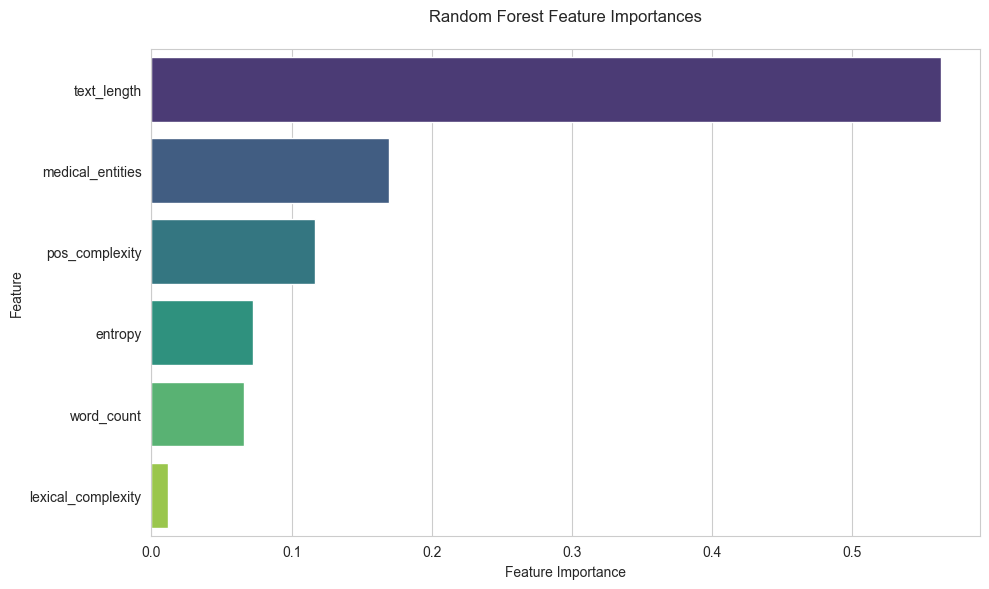

In [5]:
# Assuming your random forest model 'clf' is trained on the full feature set X (with all 6 features)
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Set the style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_importance_df,
    y='Feature',
    x='Importance',
    palette='viridis'
)

# Customize the plot
plt.title('Random Forest Feature Importances', pad=20)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
print(importances)

[0.07255217 0.01183667 0.11658221 0.16974584 0.56292533 0.06635778]


entropy: Permutation Importance = 0.0166
lexical_complexity: Permutation Importance = 0.0006
pos_complexity: Permutation Importance = 0.0402
medical_entities: Permutation Importance = 0.0410
text_length: Permutation Importance = 0.0790
word_count: Permutation Importance = 0.0100


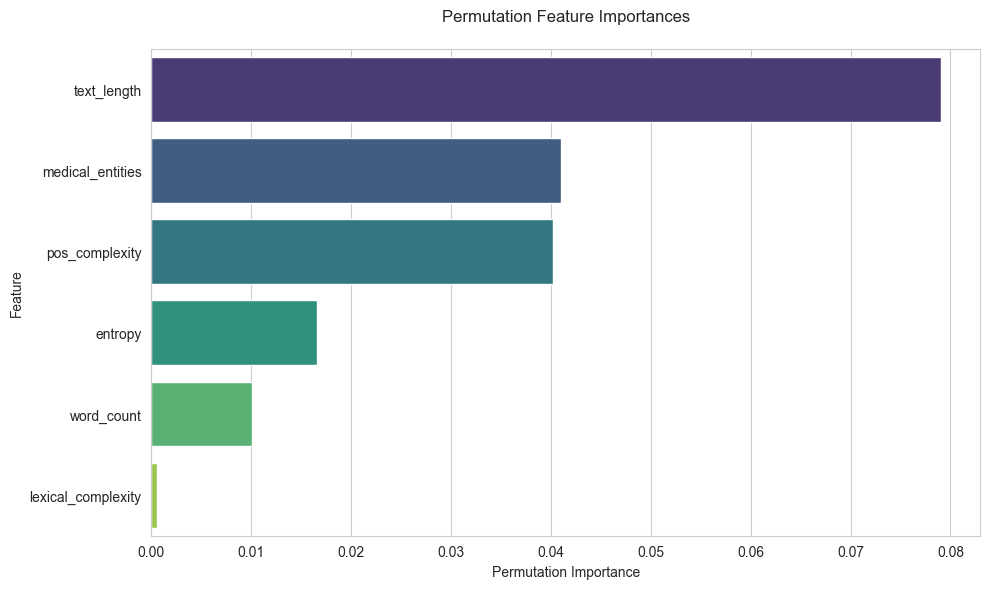

In [8]:
# Compute permutation importance on the test set
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print('FPermutation Importance mean:')
for i, feature in enumerate(X_test.columns):
    print(f"{feature}: {result.importances_mean[i]:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=perm_importance_df,
    y='Feature',
    x='Importance',
    palette='viridis'
)
plt.title('Permutation Feature Importances', pad=20)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Random Forest's Feature Importances:
This method calculates how much each feature decreases the impurity (e.g., Gini impurity) across all trees. Features with higher importance values have a greater impact on the predictions.

Permutation Importance:
By shuffling one feature and observing the drop in model performance, you can gauge how dependent the model is on that feature. This method is especially useful because it is model-agnostic and can sometimes provide more interpretable results.

In [12]:
# Baseline performance with all features
baseline_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print("Baseline Accuracy:", baseline_accuracy)

sensitivity_results = {}

for feature in X_test.columns:
    print(f"\nRemoving feature: {feature}")
    # Remove the feature from training and test sets
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])

    # Retrain a new model on the reduced dataset
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_reduced, y_train)

    # Evaluate the model
    reduced_accuracy = accuracy_score(y_test, model.predict(X_test_reduced))
    accuracy_drop = baseline_accuracy - reduced_accuracy
    sensitivity_results[feature] = accuracy_drop
    print(f"Accuracy with {feature} removed: {reduced_accuracy:.4f} (Drop: {accuracy_drop:.4f})")

print("\nSensitivity Analysis (Accuracy Drop When Removing Each Feature):")
for feature, drop in sensitivity_results.items():
    print(f"{feature}: {drop:.4f}")


Baseline Accuracy: 0.6557436255507668

Removing feature: entropy
Accuracy with entropy removed: 0.6628 (Drop: -0.0070)

Removing feature: lexical_complexity
Accuracy with lexical_complexity removed: 0.6626 (Drop: -0.0068)

Removing feature: pos_complexity
Accuracy with pos_complexity removed: 0.6466 (Drop: 0.0091)

Removing feature: medical_entities
Accuracy with medical_entities removed: 0.6436 (Drop: 0.0122)

Removing feature: text_length
Accuracy with text_length removed: 0.6219 (Drop: 0.0338)

Removing feature: word_count
Accuracy with word_count removed: 0.6628 (Drop: -0.0071)

Sensitivity Analysis (Accuracy Drop When Removing Each Feature):
entropy: -0.0070
lexical_complexity: -0.0068
pos_complexity: 0.0091
medical_entities: 0.0122
text_length: 0.0338
word_count: -0.0071


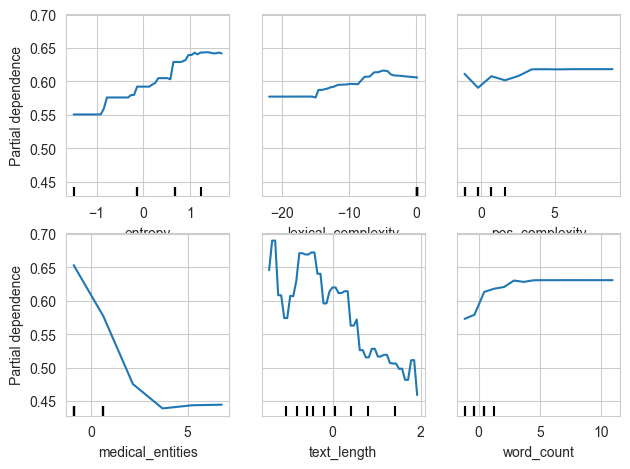

In [13]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Plot partial dependence for each feature
features_to_plot = list(X_test.columns)
PartialDependenceDisplay.from_estimator(rf_model, X_train, features_to_plot, grid_resolution=50)
plt.tight_layout()
plt.show()


In the context of a string of text, entropy measures the diversity and unpredictability of the text. Intuitively, it captures how much information is contained in the text and how "surprising" it is.

High Entropy: The text is diverse and unpredictable, with many unique words or characters appearing in an irregular pattern. This often means richer vocabulary, more complex sentence structures, or less redundancy.
Low Entropy: The text is more predictable, with repetitive words, simpler phrasing, or a smaller set of unique words.
How It Applies Here
If higher entropy increases the model's prediction, it suggests that more complex and information-rich text leads to the desired outcome.
If lower entropy is preferred, the model might favor simpler, more structured text.
Your PDP shows a nonlinear relationship—entropy initially helps the prediction but plateaus or drops at higher values. This suggests that some complexity is beneficial, but beyond a point, too much unpredictability (perhaps jargon-heavy or very complex text) might reduce clarity or effectiveness.

Providers can use this insight to craft questions that balance openness with focus. For example, they might start with a broad question like, "What brings you to the ER today?" to invite a narrative. If the response seems too brief or vague (low entropy), a follow-up such as, "Can you tell me more about the specific symptoms you're experiencing?" can encourage additional detail. Conversely, if a patient offers an overly complex or disjointed explanation (high entropy), the provider might gently steer the conversation with, "Can you summarize the main issue in a few clear points?" This approach helps ensure that the information gathered is rich enough to be clinically useful without being overwhelmed by unnecessary complexity.

The analysis reveals that the relationship between text entropy and prediction is nonlinear. Initially, as entropy increases—implying that the chief complaint text is more diverse and information-rich—the model’s prediction of admission (or discharge) improves. This suggests that a certain level of complexity and unique information aids in making a more accurate prediction. However, once entropy reaches a higher threshold, the benefit tapers off and even reverses. Excessively high entropy may indicate that the text is too unpredictable, potentially cluttered with jargon or overly complex language, which can obscure the critical information needed for decision-making. Thus, while some variability in the text is advantageous, there is an optimal balance where too much unpredictability becomes counterproductive.